In [8]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt

from shapely import wkt
from shapely.geometry import Point
from tqdm import tqdm

tqdm.pandas()

train = pd.read_csv('data/stores_train.csv')
train = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lon, train.lat)).drop(columns=['lon', 'lat'])
train = train.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

train_extra = pd.read_csv('data/stores_extra.csv')
train_extra = gpd.GeoDataFrame(train_extra, geometry=gpd.points_from_xy(train_extra.lon, train_extra.lat)).drop(columns=['lon', 'lat'])
train_extra = train_extra.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

test = pd.read_csv('data/stores_test.csv')
test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat)).drop(columns=['lon', 'lat'])
test = test.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

In [9]:
train_full = pd.concat([train, train_extra], ignore_index=True)[['store_id', 'geometry']]

def store_count_in_vicinity(row: pd.Series):
    stores_in_vicinity = train_full[train_full.distance(row.geometry) < 1000]
    return {'stores_count_lt_1km': len(stores_in_vicinity)}


# train_full = train_full.join(train_full.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
# train_full.to_parquet('derived_data/stores_count_lt_1km_train')

# test = test.join(test.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
# test.to_parquet('derived_data/stores_count_lt_1km_test')

In [15]:
stores_train = gpd.read_parquet('derived_data/stores_count_lt_1km_train')
stores_test = gpd.read_parquet('derived_data/stores_count_lt_1km_test')

stores_test_trimmed = stores_test[['store_id', 'geometry', 'stores_count_lt_1km']]
stores_test_trimmed.to_parquet('derived_data/stores_count_lt_1km_test')


In [16]:
stores_test = gpd.read_parquet('derived_data/stores_count_lt_1km_test')
stores_test

,store_id,geometry,stores_count_lt_1km
0,914206820-914239427-717245,POINT (1200806.820 8379432.793),34
1,916789157-916823770-824309,POINT (1067358.318 8224059.672),8
2,913341082-977479363-2948,POINT (1216112.410 8391314.847),125
3,889682582-889697172-28720,POINT (1164523.323 9204180.098),8
4,997991699-998006945-417222,POINT (1200594.429 8382192.955),12
...,...,...,...
8572,917323003-917383529-844309,POINT (592866.806 8236703.826),0
8573,917353379-917411824-845904,POINT (636919.593 8175248.695),11
8574,917072302-917089248-833647,POINT (1242682.011 8383798.540),23
8575,916960557-916993161-829908,POINT (574585.237 8499663.975),1


8577 8577


,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,chain_name,mall_name,geometry,stores_count_lt_1km
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,None,None,POINT (1200806.820 8379432.793),34
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,BURGER KING,None,POINT (1067358.318 8224059.672),8
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,BURGER KING,Stovner Senter,POINT (1216112.410 8391314.847),125
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,BURGER KING,None,POINT (1164523.323 9204180.098),8
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,VULKAN BURGERBAR,None,POINT (1200594.429 8382192.955),12
...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,2016,GULATING HAUGESUND,2.8.11.2,Beer and soda shop,11490601,BRÅTAVEGEN 30,GULATING GRUPPEN,None,POINT (592866.806 8236703.826),0
8573,917353379-917411824-845904,2016,STAVANGER BEER AS,2.8.11.2,Beer and soda shop,11030901,SANDVIGÅ 7,None,None,POINT (636919.593 8175248.695),11
8574,917072302-917089248-833647,2016,GULATING ØLUTSALG OG PUB,2.8.11.2,Beer and soda shop,2270103,GARDERBAKKEN 6,GULATING GRUPPEN,None,POINT (1242682.011 8383798.540),23
8575,916960557-916993161-829908,2016,VI BRYGGER BUTIKKDRIFT AS,2.8.11.2,Beer and soda shop,12470701,RAVNANGERVEGEN,None,None,POINT (574585.237 8499663.975),1


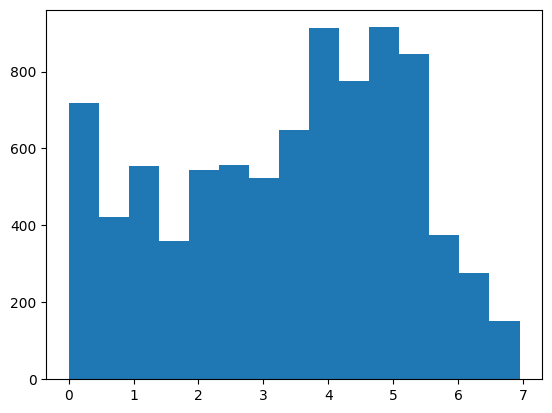

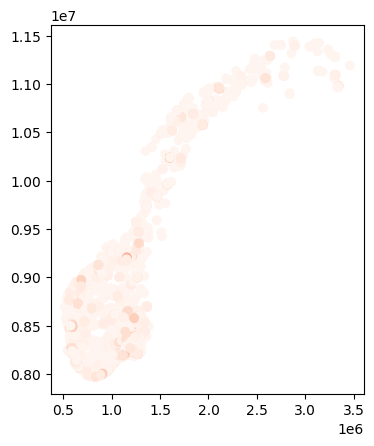

In [11]:
stores = gpd.read_parquet('derived_data/stores_count_lt_1km_test')
print(len(stores), len(test))
plt.hist(np.log1p(stores.stores_count_lt_1km), bins=15)


train_w_counts = pd.merge(test, stores.drop(columns=['geometry']), on='store_id', how='left')
train_w_counts = gpd.GeoDataFrame(train_w_counts, geometry=train_w_counts.geometry)
# train_w_counts = train_w_counts.set_crs('epsg:3857')

train_w_counts.plot(column='stores_count_lt_1km', cmap='Reds')

# stores[stores.stores_count_lt_1km > 100].plot(column='stores_count_lt_1km', cmap='Reds')

stores